# Results Plots for FairGBM paper and presentation

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

In [2]:
# Plotting Parameters
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (5, 4)

In [3]:
# Directories
DATASET_NAME = "AOF-FairHO"
#DATASET_NAME = "Adult-2021"
#DATASET_NAME = "AOF-Fairbench"

RESULTS_DIR = Path("../results") / DATASET_NAME
assert RESULTS_DIR.exists() and RESULTS_DIR.is_dir()

IMGS_DIR = Path("imgs") / DATASET_NAME
IMGS_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
from utils.datasets import get_dataset_details
dataset_details = get_dataset_details(DATASET_NAME)
globals().update(dataset_details)

Using dataset AOF-FairHO!


## Load results CSVs and aggregate

In [5]:
results_csvs = dict()
for f in RESULTS_DIR.iterdir():
    if f.suffix == ".csv" and f.stem != "aggregated-results":
        # Read file
        df = pd.read_csv(f, index_col=(0,1))
        
        # Add an extra index column (to specify the current file)
        df = df.set_index([pd.Series([f.stem for _ in range(len(df))]), df.index])

        # Add to results dict
        results_csvs[f.stem] = df

In [6]:
# Check if files have matching columns
columns = None
for f in results_csvs.values():
    if columns is None:
        columns = list(f.columns)
    else:
        assert set(columns) == set(f.columns)

In [7]:
# Aggregate results
results_df = pd.concat(objs=results_csvs.values(), axis=0, ignore_index=False)

In [8]:
# Minor data cleaning
if "AOF" in DATASET_NAME:
    if len(results_df.loc[pd.IndexSlice[:, "LightGBM.062", :], :]) > 0:
        # There was a problem on the cluster while this model was being evaluated (TODO! re-run evals for this single model!)
        results_df = results_df.drop(results_df.loc[pd.IndexSlice[:, "LightGBM.062", :], :].index)

In [9]:
results_df_path = RESULTS_DIR / "aggregated-results.csv"
results_df.to_csv(results_df_path)

Use the following line to load the results next time!
```py
results_df = pd.read_csv(results_df_path, index_col=(0,1,2))
```
___

## Organize results

In [10]:
import re

def organize_results(results_df: pd.DataFrame, matrix_type: str):
    assert matrix_type in results_df.reset_index()["level_2"].unique()
    
    # Regex to match model and id
    expression = re.compile(r"^(?P<model>.*)[\.](?P<id>\d+)$")

    data = list()
    index = list()
    for (file, name, curr_matrix_type), row in results_df.iterrows():

        # Collect rows from this matrix type
        if curr_matrix_type == matrix_type:
            m = expression.fullmatch(name)
            if m is None:
                logging.error(f"Name '{name}' doesn't match given regex.")
                continue
                
            is_randomized_clf = "randomized-clf=True" in file
            is_using_val_threshold = "val-threshold=True" in file

            index.append({
                "model": m["model"] + (".Rand-Clf" if is_randomized_clf else ""),
                "id": m["id"],
            })

            data.append(row)

    # Transform list of dicts into DF
    index_df = pd.DataFrame(index)

    # Compose results
    return pd.DataFrame(data).set_index([
        pd.Series(index_df[key], name=key)
        for key in index_df.columns
    ])

In [11]:
"""
test_results = organize_results(results_df, matrix_type="test")
val_results = organize_results(results_df, matrix_type="validation")
"""

MATRIX_TYPE = "validation"
results = organize_results(results_df, matrix_type=MATRIX_TYPE)
results["model"] = results.index.get_level_values(0)

test_results = organize_results(results_df, matrix_type="test")
test_results["model"] = test_results.index.get_level_values(0)

## Drop a bunch of models :)
- Drop all "equalized prevalence", "LightGBM.Rand-Clf", and FairGBM variants (besides BCE+BCE)

In [12]:
if "AOF" in DATASET_NAME:
    fairgbm_variants_filter = np.array([("FairGBM" in name and "BCE+BCE" not in name) for name in results["model"]])
else:
    fairgbm_variants_filter = np.array([("FairGBM" in name and "params-exploration" not in name) for name in results["model"]])

lightgbm_randomized_clf_filter = np.array([("LightGBM" in name and "Rand-Clf" in name) for name in results["model"]])
equalized_prev_filter = np.array(["equalized-prev" in name for name in results["model"]])

results = results[
    (~fairgbm_variants_filter)             # Discard other FairGBM variants (besides BCE+BCE)
    & (~lightgbm_randomized_clf_filter)    # Discard LightGBM randomized classifier
    & (~equalized_prev_filter)             # Discard all models trained on equalized-prev data
]

## Selection filters

In [13]:
unawareness_filter = np.array(["unaware" in name.lower() for name in results["model"]])
randomized_clf_filter = np.array(["rand-clf" in name.lower() for name in results["model"]])

fairgbm_filter = np.array(["FairGBM" in name for name in results["model"]])
lightgbm_filter = np.array(["LightGBM" in name for name in results["model"]])

# AOF baselines
tfco_filter = np.array(["tfco" in name.lower() for name in results["model"]])
fairlearn_gs_filter = np.array(["fairlearn-gs" in name.lower() for name in results["model"]])
fairlearn_gs_10x10_filter = np.array(["fairlearn-gs-10x10" in name.lower() for name in results["model"]])
baselines_filter = tfco_filter | fairlearn_gs_filter

# Adult baselines
if "Adult" in DATASET_NAME:
    fairlearn_eg_filter = np.array(["fairlearn-eg" in name.lower() for name in results["model"]])
    baselines_filter = fairlearn_eg_filter | fairlearn_gs_filter
elif "AOF" in DATASET_NAME:
    baselines_filter = fairlearn_gs_filter

In [14]:
models_in_comparison_filter = (
    (fairgbm_filter & randomized_clf_filter)
    | (lightgbm_filter & ~unawareness_filter)
    | (baselines_filter)
)

___

In [15]:
# Rename models
if "AOF" in DATASET_NAME:
    name_map = {
        "FairGBM.BCE+BCE.Rand-Clf": "FairGBM",
        "LightGBM": "LightGBM",
        "Fairlearn-GS-10x10-LGBM": "Fairlearn GS (LGBM)",
        "Fairlearn-GS-LGBM": "RS Reweighing (LGBM)",
    }

elif "Adult" in DATASET_NAME:
    name_map = {
        "FairGBM-params-exploration.Rand-Clf": "FairGBM",
        "LightGBM": "LightGBM",
        "Fairlearn-GS-10x10-LGBM": "Fairlearn GS (LGBM)",
        "Fairlearn-GS-LGBM": "RS Reweighing (LGBM)",
        "Fairlearn-EG-LGBM": "Fairlearn EG (LGBM)",
    }

results["model"] = results["model"].apply(lambda val: name_map.get(val, val))
model_order = list(name_map.values())

___

# Plots!

In [16]:
perf_axis_label = f"Performance ({'TPR' if perf_metric == 'tpr' else perf_metric.capitalize()})"
fair_axis_label = f"Fairness ({'FNR ratio' if fair_metric == 'fnr_ratio' else 'FPR ratio'})"
#fair_axis_label = f"Fairness ({'equal opp.' if fair_metric == 'fnr_ratio' else 'pred. equality'})"

In [17]:
model_order

['FairGBM', 'LightGBM', 'Fairlearn GS (LGBM)', 'RS Reweighing (LGBM)']

In [18]:
if "AOF" in DATASET_NAME:
    palette = sns.color_palette(n_colors=len(model_order))
else:
    palette = sns.color_palette(n_colors=len(model_order) + 2)
    palette = palette[:len(model_order)-1] + [palette[-1]]

sns.set_palette(palette)
palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]

## All models in comparison

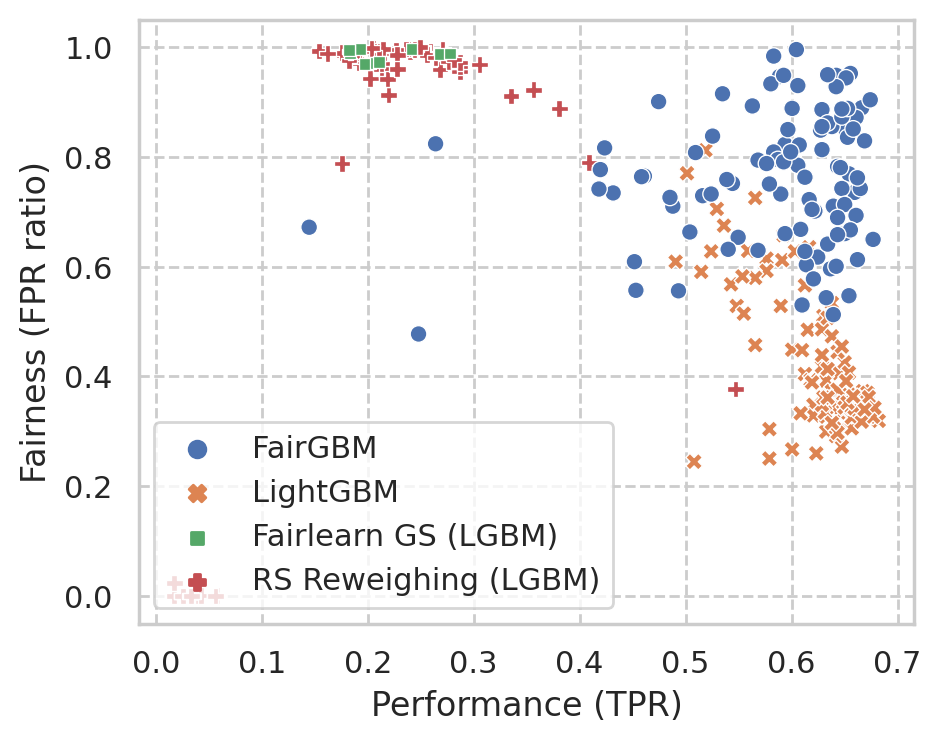

In [19]:
curr_plot_results = results[models_in_comparison_filter]
curr_plot_results = curr_plot_results.reset_index(drop=True).sort_values("model", ascending=False)

sns.scatterplot(
    data=curr_plot_results,
    x=perf_metric, y=fair_metric,
    hue="model", style="model",
    hue_order=model_order, style_order=model_order,
)

# Figure settings
#plt.title("Test data")
plt.legend(loc="lower left")

plt.xlabel(perf_axis_label)
plt.ylabel(fair_axis_label)

"""
if "AOF" in DATASET_NAME:
    plt.ylim(0, 1.02)
    plt.xlim(0, 0.71)
"""
if "Adult" in DATASET_NAME:
    plt.ylim(0.6, 1.02)
    plt.xlim(0.7, 0.825)

plt.savefig(IMGS_DIR / f"{MATRIX_TYPE}.all-models.png", bbox_inches='tight')

#plt.gcf().set_size_inches((8, 6))
plt.show()

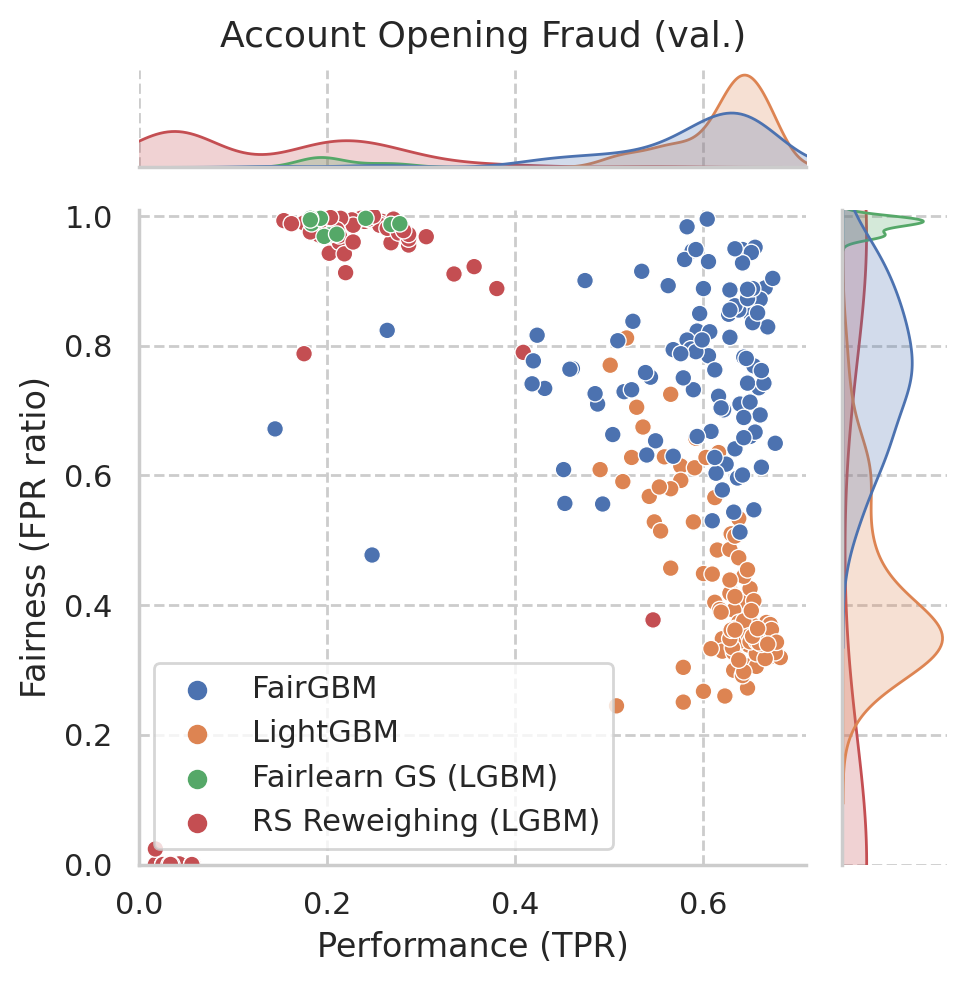

In [20]:
curr_plot_results = results[models_in_comparison_filter]
if "AOF" in DATASET_NAME:
    curr_plot_results = curr_plot_results.reset_index(drop=True).sort_values("model", ascending=False)

p = sns.jointplot(
    data=curr_plot_results,
    x=perf_metric, y=fair_metric,
    hue="model", hue_order=model_order,
    height=plt.rcParams['figure.figsize'][0],
    **(
        {"xlim": (0, 0.71), "ylim": (0, 1.01)}
        if "AOF" in DATASET_NAME else
        {"xlim": (0.73, 0.823), "ylim": (0, 1.01)}
    )
    #joint_kws={"zorder": -10}
    #joint_kws={"markers": "+"}
)

if "AOF" in DATASET_NAME:
    p.fig.suptitle(f"Account Opening Fraud ({'val.' if 'val' in MATRIX_TYPE else 'test'})", fontsize=13)
elif "Adult" in DATASET_NAME:
    p.fig.suptitle(f"ACSIncome-Adult ({'val.' if 'val' in MATRIX_TYPE else 'test'})", fontsize=13)

p.fig.tight_layout()
p.fig.subplots_adjust(top=0.93) # Reduce plot to make room for title
p.set_axis_labels(perf_axis_label, fair_axis_label)

p.ax_joint.legend(loc="lower left")

p.savefig(IMGS_DIR / f"{MATRIX_TYPE}.all-models.jointplot.png", bbox_inches='tight')

plt.show()

## "Arrows" plot: map each LightGBM to corresponding FairGBM

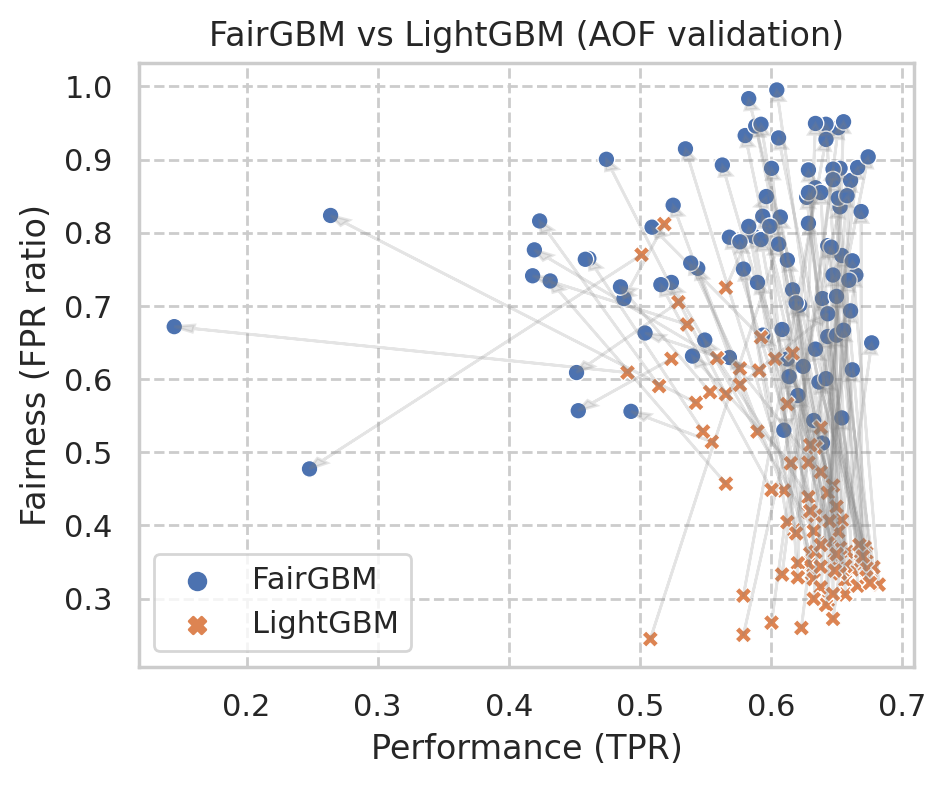

In [21]:
curr_plot_results = results[
    (fairgbm_filter & randomized_clf_filter)
    | (lightgbm_filter & ~unawareness_filter)
]

sns.scatterplot(
    data=curr_plot_results,
    x=perf_metric, y=fair_metric,
    hue="model", style="model",
    hue_order=model_order[:2], style_order=model_order[:2],
)

# Draw arrows from each LightGBM to each corresponding FairGBM
fairgbm_results = curr_plot_results[curr_plot_results["model"] == "FairGBM"].reset_index(level=1)
lightgbm_results = curr_plot_results[curr_plot_results["model"] == "LightGBM"].reset_index(level=1)
#assert len(fairgbm_results) == len(lightgbm_results)

change_vectors = []
for idx, row in lightgbm_results.iterrows():
    model_id = row.id

    lightgbm_row = lightgbm_results[lightgbm_results["id"] == model_id]
    fairgbm_row = fairgbm_results[fairgbm_results["id"] == model_id]

    assert len(lightgbm_row) == len(fairgbm_row) == 1
    lightgbm_row = lightgbm_row.iloc[0]
    fairgbm_row = fairgbm_row.iloc[0]

    lgbm_x, lgbm_y = lightgbm_row[perf_metric], lightgbm_row[fair_metric]
    fgbm_x, fgbm_y = fairgbm_row[perf_metric], fairgbm_row[fair_metric]
    
    change_vectors.append((fgbm_x - lgbm_x, fgbm_y - lgbm_y))

    plt.arrow(
        x=lgbm_x, y=lgbm_y,
        dx=(fgbm_x - lgbm_x), dy=(fgbm_y - lgbm_y),
        color="grey",
        head_width=(1e-2 if "AOF" in DATASET_NAME else 3e-3),
        width=1e-4,
        length_includes_head=True,
        alpha=0.2,
    )


    """
    prop = dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",shrinkA=0,shrinkB=0,color="grey",alpha=0.5)
    plt.annotate("", xy=(fgbm_x - lgbm_x, fgbm_y - lgbm_y), xytext=(lgbm_x, lgbm_y), arrowprops=prop)
    """


# Draw arrow with average change
avg_lgbm_x = lightgbm_results[perf_metric].mean()
avg_lgbm_y = lightgbm_results[fair_metric].mean()

change_vectors = np.matrix(change_vectors)

"""
plt.arrow(
    x=avg_lgbm_x, y=avg_lgbm_y,
    dx=np.mean(change_vectors[:, 0]), dy=np.mean(change_vectors[:, 1]),
    color="#4cbb17",
    head_width=(1e-2 if "AOF" in DATASET_NAME else 3e-3),
    width=(2e-3 if "AOF" in DATASET_NAME else 2e-4),
    #color="green",
    #head_width=(2e-2 if "AOF" in DATASET_NAME else 3e-3),
    #width=(5e-3 if "AOF" in DATASET_NAME else 2e-4),
    #label="avg. change",
)
"""

# Figure settings
plt.title("FairGBM vs LightGBM (AOF validation)")
plt.legend(loc="lower left")

plt.xlabel(perf_axis_label)
plt.ylabel(fair_axis_label)

"""
if "AOF" in DATASET_NAME:
    plt.ylim(0, 1.02)
    plt.xlim(0, 0.71)
"""
if "Adult" in DATASET_NAME:
    plt.ylim(0.6, 1.02)
    plt.xlim(0.7, 0.825)

plt.savefig(IMGS_DIR / f"{MATRIX_TYPE}.LightGBM-vs-FairGBM.arrows-plot.png", bbox_inches='tight')

plt.show()    

## Compare randomized classifiers

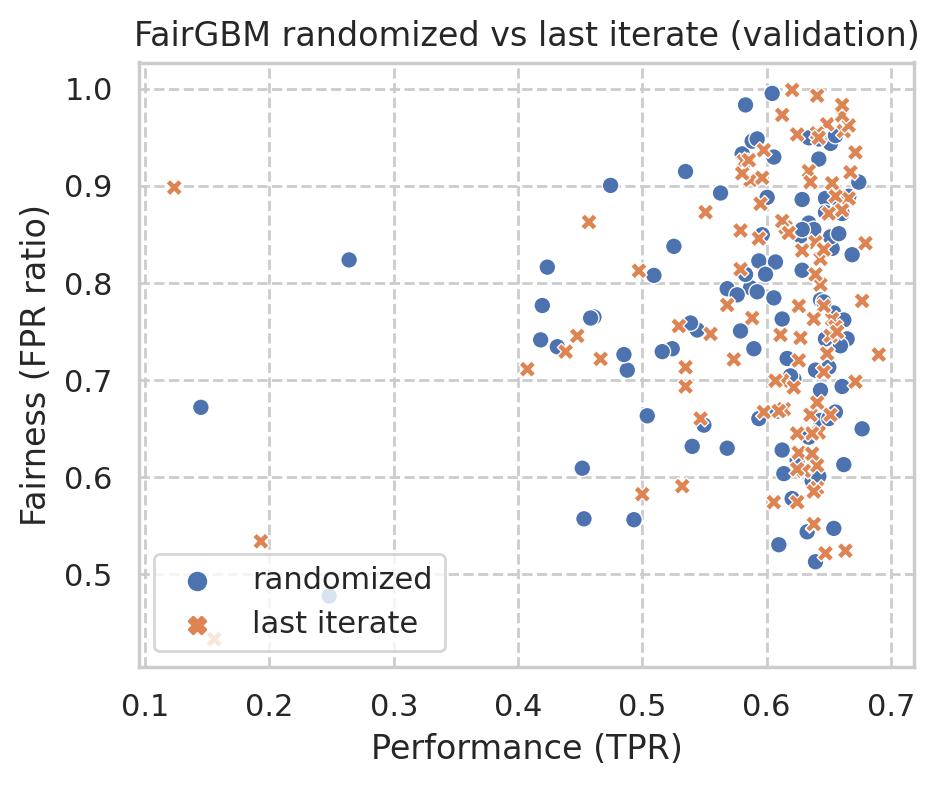

In [22]:
rnd_clf_plot_results = results[fairgbm_filter].copy()
rnd_clf_plot_results["model"] = rnd_clf_plot_results["model"].apply(
    lambda val: "randomized" if val == "FairGBM" else "last iterate")

order = ["randomized", "last iterate"]

sns.scatterplot(
    data=rnd_clf_plot_results,
    x=perf_metric, y=fair_metric,
    hue="model", style="model",
    hue_order=order, style_order=order,
)

# Figure settings
plt.title(f"FairGBM randomized vs last iterate ({MATRIX_TYPE})")
plt.legend(loc="lower left")

plt.xlabel(perf_axis_label)
plt.ylabel(fair_axis_label)

if "Adult" in DATASET_NAME:
    plt.ylim(0.85, 1.01)
    plt.xlim(0.77, 0.82)
    
plt.savefig(IMGS_DIR / f"{MATRIX_TYPE}.FairGBM.randomized-vs-last-iterate.png", bbox_inches='tight')

plt.show()

## Performance as a function of HPT trials

In [23]:
from utils.show_your_work import one_plot
from utils.show_your_work.expected_max_performance import samplemax

/tmp/ipykernel_1273290/1166959946.py:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


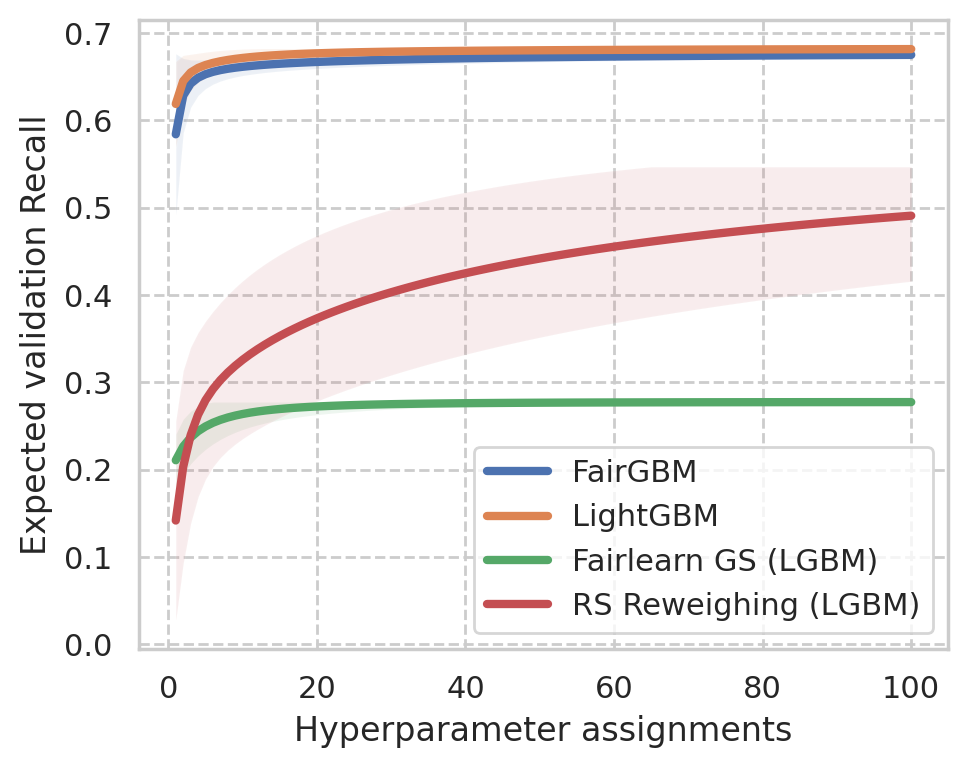

In [24]:
models = results[models_in_comparison_filter]["model"].unique()

axis = None
for m in model_order:
    perf = results[results["model"] == m][perf_metric]
    if len(perf) < 100:
        perf = np.random.choice(perf, size=100, replace=True)

    axis = one_plot(
        samplemax(perf),
        data_name=f"{MATRIX_TYPE.capitalize()} results",
        performance_metric=("Recall" if perf_metric == "tpr" else perf_metric.capitalize()),
        label=(m if "FairGBM" not in m else "FairGBM"),
        axis=axis,
    )

# Image configs
plt.legend(loc="lower right")

if "Adult" in DATASET_NAME:
    plt.ylim(0.80, 0.825)

plt.gcf().set_dpi(200)
plt.gcf().set_size_inches((5, 4))

plt.gcf().savefig(IMGS_DIR / f"{MATRIX_TYPE}.show-your-work.performace-wrt-HPT.png", bbox_inches='tight')
plt.show()

### > Same plot, but discarding unfair models!

In [25]:
from typing import Tuple
import numpy as np

def get_perf_fair(
        model: str, results: pd.DataFrame,
        fair_threshold: float = 0.8,
    ) -> Tuple[np.ndarray, np.ndarray]:
    
    # Select results for the current model
    model_results = results[results["model"] == model]
    
    # Set metrics to zero for results below fairness threshold
    model_results = model_results.where(model_results[fair_metric] > fair_threshold, other=0.0)

    return model_results[perf_metric].to_numpy(), model_results[fair_metric].to_numpy()

/tmp/ipykernel_1273290/1852861564.py:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


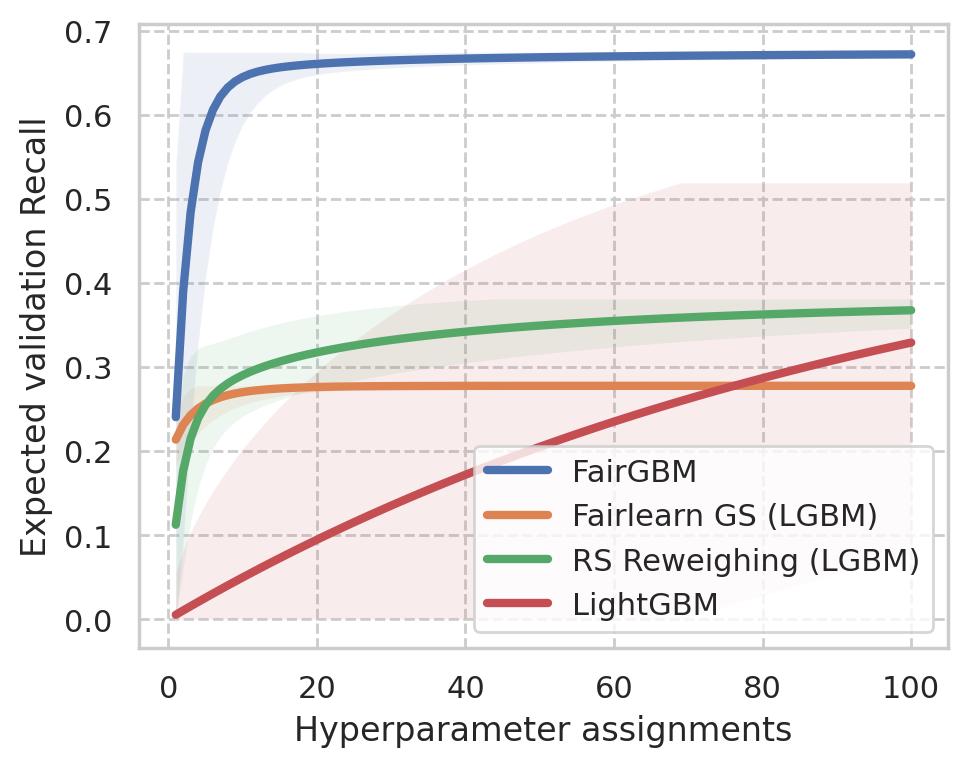

In [26]:
fairness_threshold = 0.8
models = results[models_in_comparison_filter]["model"].unique()

axis = None
for m in models:
    perf, _fairness = get_perf_fair(m, results=results, fair_threshold=fairness_threshold)

    if len(perf) < 100:
        perf = np.random.choice(perf, size=100, replace=True)

    axis = one_plot(
        samplemax(perf),
        data_name=f"Performance, with $fairness \geq {fairness_threshold}$ ({MATRIX_TYPE})",
        performance_metric=("Recall" if perf_metric == "tpr" else perf_metric),
        label=(m if "FairGBM" not in m else "FairGBM"),
        axis=axis,
        save_plot_dir=IMGS_DIR,
    )

# Image configs
plt.legend(loc="lower right")

plt.gcf().set_dpi(200)
plt.gcf().set_size_inches((5, 4))

plt.gcf().savefig(IMGS_DIR / f"{MATRIX_TYPE}.show-your-work.performace-wrt-HPT.FAIRNESS-geq-{fairness_threshold:.2}.png", bbox_inches='tight')
plt.show()

___
___
# Best fair model

In [27]:
PERF_WEIGHT = 0.5
FAIRNESS_THRESHOLD = 0.8

def best_fair_models(models: pd.DataFrame, fairness_threshold=None):
    fairness_threshold = fairness_threshold or FAIRNESS_THRESHOLD
    fair_models = models[models[fair_metric] > fairness_threshold]
    if len(fair_models) > 0:
        return fair_models.sort_values(perf_metric, ascending=False).iloc[0]
    else:
        return models.sort_values(fair_metric, ascending=False).iloc[0]


def best_tradeoff(models: pd.DataFrame, perf_weight=None):
    perf_weight = perf_weight or PERF_WEIGHT
    assert 0 <= perf_weight <= 1
    df = models.copy()
    df["tradeoff"] = df[fair_metric] * (1 - perf_weight) + df[perf_metric] * perf_weight
    return df.sort_values("tradeoff", ascending=False).iloc[0]


def model_selection(models: pd.DataFrame):
    #return best_fair_models(models)
    return best_tradeoff(models)

In [28]:
curr_results = results[models_in_comparison_filter]

for m in model_order:
    model_results = curr_results[curr_results["model"] == m]
    curr_model = model_selection(model_results)

    print(f"** {m} - {curr_model.name} **")
    print(f"\t> VAL. Fairness: {curr_model[fair_metric]:.3}; Perf.: {curr_model[perf_metric]:.3}")

    # Corresponding TEST results:
    curr_model_test = test_results.loc[curr_model.name]
    print(f"\t> TEST Fairness: {curr_model_test[fair_metric]:.3}; Perf.: {curr_model_test[perf_metric]:.3}")

    print()

** FairGBM - ('FairGBM.BCE+BCE.Rand-Clf', '048') **
	> VAL. Fairness: 0.952; Perf.: 0.655
	> TEST Fairness: 0.915; Perf.: 0.666

** LightGBM - ('LightGBM', '003') **
	> VAL. Fairness: 0.812; Perf.: 0.519
	> TEST Fairness: 0.866; Perf.: 0.526

** Fairlearn GS (LGBM) - ('Fairlearn-GS-10x10-LGBM', '009') **
	> VAL. Fairness: 0.988; Perf.: 0.277
	> TEST Fairness: 0.999; Perf.: 0.284

** RS Reweighing (LGBM) - ('Fairlearn-GS-LGBM', '013') **
	> VAL. Fairness: 0.922; Perf.: 0.357
	> TEST Fairness: 0.935; Perf.: 0.359

